# Vodafone Online Review Ingestion Pipeline Plus Exploratory Data Analysis (EDA) {-}

Subject: MA5853 Project 1 <br>
Project: Project 008 - Vodafone Net Promoter Text Analysis <br>
Author: Nikki Fitzherbert

#### Part 1: Environment setup and data import {-}

In [1]:
# import every library that's required
import gensim
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd
import regex as re
import seaborn as sns

import en_core_web_trf

from gensim.corpora import Dictionary
from textblob import TextBlob, Word, Blobber
from wordcloud import WordCloud

# just a setting the author's system needs to plot matplotlib charts
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# load the desired English language model
# in this notebook, the transformer pipeline model is used. This is a larger and slower pipeline compared to the "sm",
#  "md" or "lg" models, which are optimised for use on a CPU, but is more accurate.
# see https://spacy.io/models/en for more information
nlp = en_core_web_trf.load()
# the normal way to do it is:
#   import spacy
#   nlp_sm = en_core_web_sm.load()

# an alternative, and more commonly seen method (which doesn't work on the author's system) is:
# import spacy
# nlp = spacy.load("en_core_web_trf")
# see https://spacy.io/models/en for the english model performance statistics

In [80]:
# load the data
vodafone_reviews = pd.read_csv('vodafone_reviews1903.csv')

# examine the first few rows
vodafone_reviews.head()

,title,review,score
0,Vodaphone Almost Ruined My Life - Stolen Ident...,My email and password were part of a company d...,1
1,Misguided Sale,"Misguided SaleCouple of days ago, I was told t...",1
2,Worst network,Worst network for data in Australia. I used Vo...,1
3,Insurance contract with them is bulshit,They charged me for over a year a plan with in...,1
4,RECORD all your phonecalls with them when you ...,My parents and I have been with Vodafone for a...,1


#### Part 2: Preliminary EDA

In [81]:
# define functions to classify each review into an NPS group
def create_NPS_group(row):
    if row.score <= 3:
        group = 'Detractor'
    elif row.score == 4:
        group = 'Passive'
    else:
        group = 'Promoter'
    return group

def create_NPS_class(row):
    if row.nps_group == 'Detractor':
        nps_class = -1
    elif row.nps_group == 'Passive':
        nps_class = 0
    else:
        nps_class = 1
    return nps_class

vodafone_reviews['nps_group'] = vodafone_reviews.apply(create_NPS_group, axis=1)
vodafone_reviews['nps_class'] = vodafone_reviews.apply(create_NPS_class, axis=1)

1    1502
2     110
3      55
4      82
5     154
dtype: int64
Detractor    1667
Passive        82
Promoter      154
dtype: int64


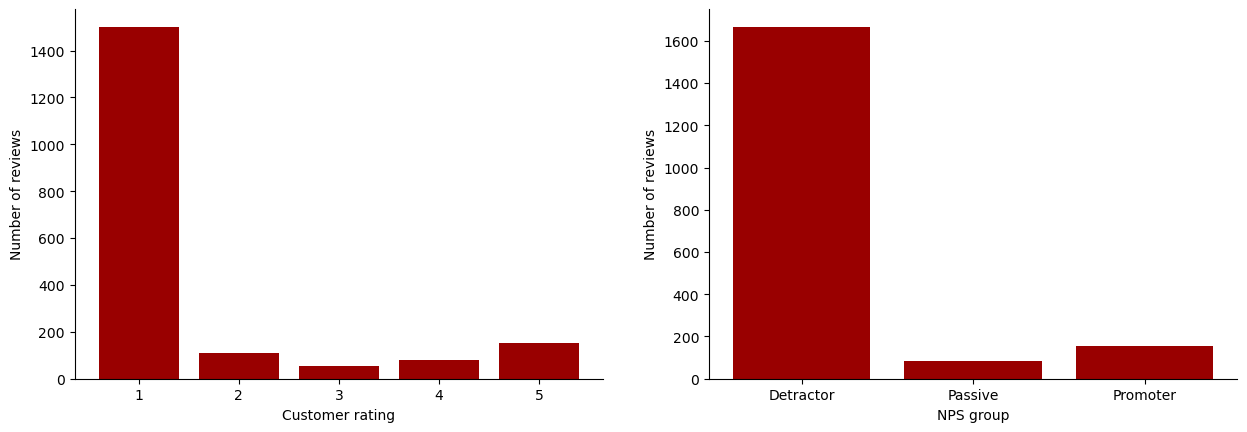

In [62]:
# plot the number of reviews by customer rating and NPS group
reviews = pd.value_counts(vodafone_reviews.score.values).sort_index()
reviews2 = pd.value_counts(vodafone_reviews.nps_group.values).sort_index()
print(reviews)
print(reviews2)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].bar(x=reviews.index, height=reviews.values, color='#990000')
axs[0].set_xlabel('Customer rating')
axs[0].set_ylabel('Number of reviews')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].bar(x=reviews2.index, height=reviews2.values, color='#990000')
axs[1].set_xlabel('NPS group')
axs[1].set_ylabel('Number of reviews')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False);
# plt.show()

# reset the default figure size
plt.rcdefaults()

In [82]:
# combine the title and review columns together
vodafone_reviews['text'] = vodafone_reviews.apply(lambda x: x.title + '. ' + x.review, axis=1)

In [83]:
# calculate character and word lengths of the combined text and obtain some basic descriptive statistics
vodafone_reviews['text_num_chars'] = vodafone_reviews.title.apply(lambda x: len(x))
vodafone_reviews['text_num_words'] = vodafone_reviews.title.apply(lambda x: len(re.findall(r'\w+', x)))

descriptive_statistics = vodafone_reviews.describe()
descriptive_statistics

,score,nps_class,text_num_chars,text_num_words
count,1903.000000,1903.000000,1903.000000,1903.000000
mean,1.568576,-0.795060,31.642144,5.248029
std,1.238363,0.570052,21.713788,3.957644
min,1.000000,-1.000000,2.000000,1.000000
25%,1.000000,-1.000000,16.000000,2.000000
50%,1.000000,-1.000000,26.000000,4.000000
75%,1.000000,-1.000000,41.000000,7.000000
max,5.000000,1.000000,121.000000,26.000000


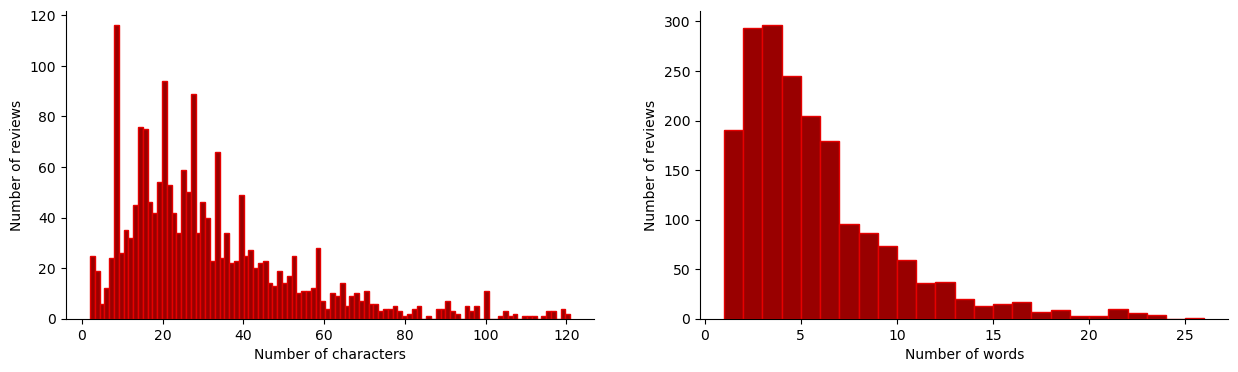

In [84]:
# plot the distribution of character and word lengths
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].hist(vodafone_reviews.text_num_chars, bins=100, edgecolor='#E60000', color='#990000')
axs[0].set_xlabel('Number of characters')
axs[0].set_ylabel('Number of reviews')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].hist(vodafone_reviews.text_num_words, bins=25, edgecolor='#E60000', color='#990000')
axs[1].set_xlabel('Number of words')
axs[1].set_ylabel('Number of reviews')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False);
# plt.show()

# reset the default figure size
plt.rcdefaults()

In [64]:
# define a function to display a kde plot of any possible combination of nps group members
def plot_kde_plot(choice=1):
    if choice == 1:
        data = vodafone_reviews[vodafone_reviews.nps_group.isin(["Promoter", "Detractor"])]

        fig, axs = plt.subplots(1, 2, figsize=(15, 4))
        p = sns.kdeplot(ax=axs[0], data=data, x='text_num_chars', hue='nps_group', fill=True,
                        common_norm=False, palette=['#990000', '#4a4d4e'], legend=False)
        p.spines['right'].set_visible(False)
        p.spines['top'].set_visible(False)
        p.set_xlabel("Number of characters in review")
        p.legend(labels=["Promoter", "Detractor"], title = "NPS group")

        p2 = sns.kdeplot(ax=axs[1], data=data, x='text_num_words', hue='nps_group', fill=True,
                        common_norm=False, palette=['#990000', '#4a4d4e'], legend=False)
        p2.spines['right'].set_visible(False)
        p2.spines['top'].set_visible(False)
        p2.set_xlabel("Number of words in review")
        p2.legend(labels=["Promoter", "Detractor"], title = "NPS group")
    elif choice == 2:
        fig, axs = plt.subplots(1, 2, figsize=(15, 4))
        p = sns.kdeplot(ax=axs[0], data=vodafone_reviews, x='text_num_chars', hue='nps_group', fill=True,
                        common_norm=False, palette=['#990000', '#4a4d4e', '#007c92'], legend=False)
        p.spines['right'].set_visible(False)
        p.spines['top'].set_visible(False)
        p.set_xlabel("Number of characters in review")
        p.legend(labels=["Promoter", "Passive", "Detractor"], title="NPS group")

        p2 = sns.kdeplot(ax=axs[1], data=vodafone_reviews, x='text_num_words', hue='nps_group', fill=True,
                         common_norm=False, palette=['#990000', '#4a4d4e', '#007c92'], legend=False)
        p2.spines['right'].set_visible(False)
        p2.spines['top'].set_visible(False)
        p2.set_xlabel("Number of words in review")
        p2.legend(labels=["Promoter", "Passive", "Detractor"], title="NPS group")
    elif choice == 3:
        data = vodafone_reviews[vodafone_reviews.nps_group.isin(["Promoter", "Passive"])]

        fig, axs = plt.subplots(1, 2, figsize=(15, 4))
        p = sns.kdeplot(ax=axs[0], data=data, x='text_num_chars', hue='nps_group', fill=True,
                        common_norm=False, palette=['#007c92', '#4a4d4e'], legend=False)
        p.spines['right'].set_visible(False)
        p.spines['top'].set_visible(False)
        p.set_xlabel("Number of characters in review")
        p.legend(labels=["Promoter", "Passive"], title="NPS group")

        p2 = sns.kdeplot(ax=axs[1], data=data, x='text_num_words', hue='nps_group', fill=True,
                         common_norm=False, palette=['#007c92', '#4a4d4e'], legend=False)
        p2.spines['right'].set_visible(False)
        p2.spines['top'].set_visible(False)
        p2.set_xlabel("Number of words in review")
        p2.legend(labels=["Promoter", "Passive"], title="NPS group")
    elif choice == 4:
        data = vodafone_reviews[vodafone_reviews.nps_group.isin(["Detractor", "Passive"])]

        fig, axs = plt.subplots(1, 2, figsize=(15, 4))
        p = sns.kdeplot(ax=axs[0], data=data, x='text_num_chars', hue='nps_group', fill=True,
                        common_norm=False, palette=['#990000', '#007c92'], legend=False)
        p.spines['right'].set_visible(False)
        p.spines['top'].set_visible(False)
        p.set_xlabel("Number of characters in review")
        p.legend(labels=["Passive", "Detractor"], title="NPS group")

        p2 = sns.kdeplot(ax=axs[1], data=data, x='text_num_words', hue='nps_group', fill=True,
                         common_norm=False, palette=['#990000', '#007c92'], legend=False)
        p2.spines['right'].set_visible(False)
        p2.spines['top'].set_visible(False)
        p2.set_xlabel("Number of words in review")
        p2.legend(labels=["Passive", "Detractor"], title="NPS group")

# reset the default figure size
plt.rcdefaults()

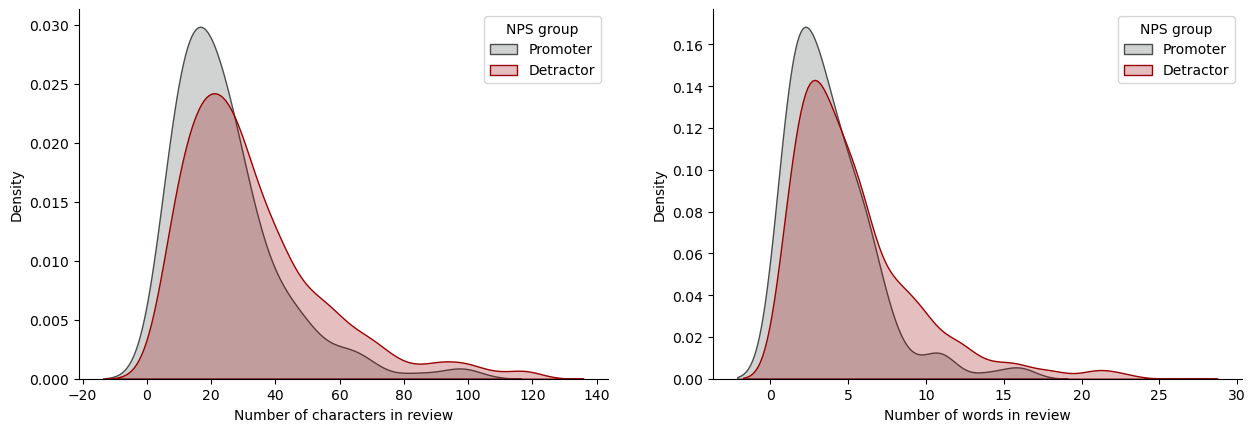

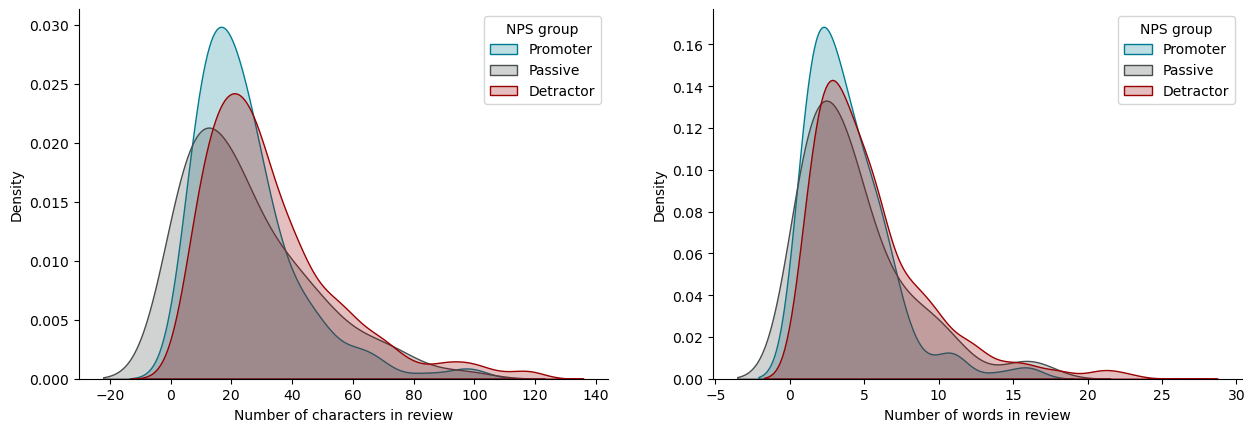

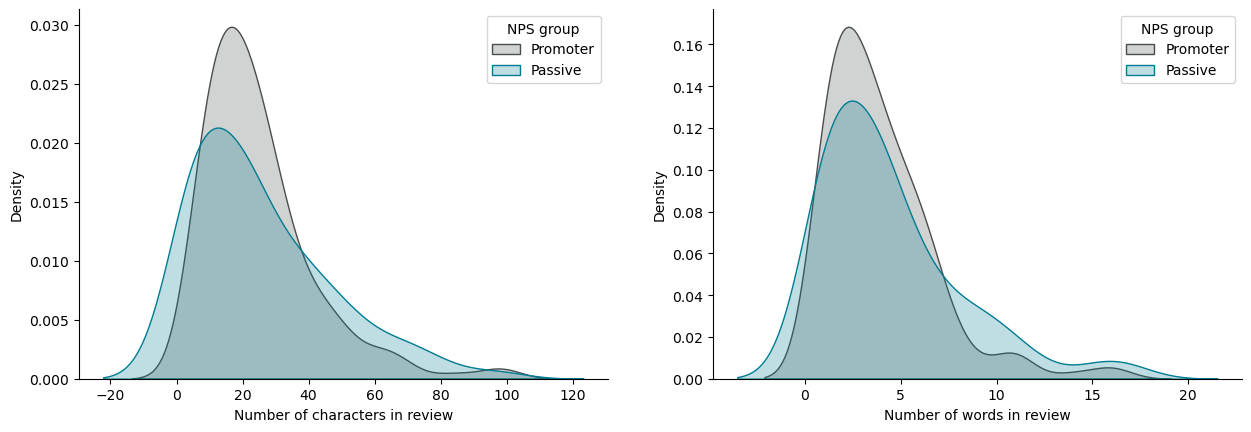

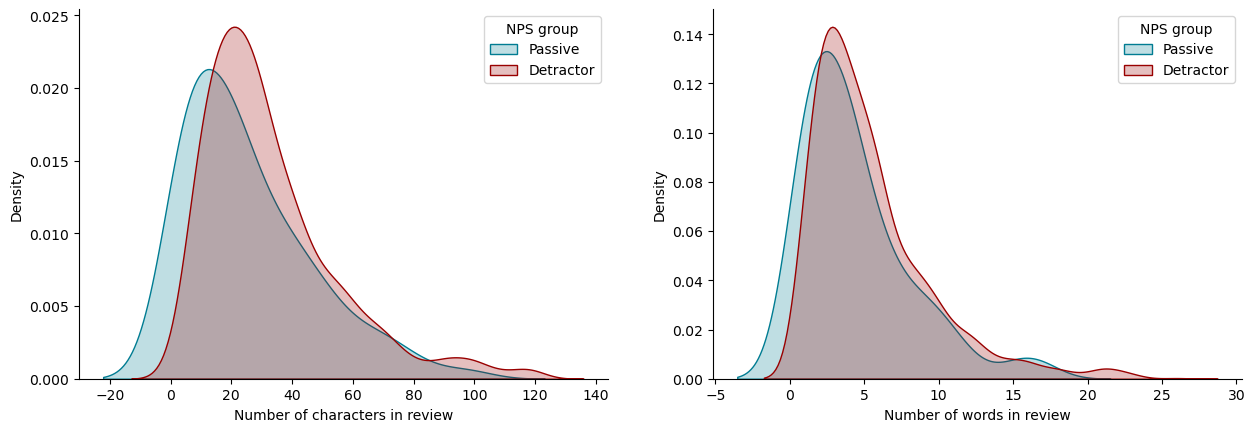

In [85]:
# 1 = detractor & promoter
# 2 = all
# 3 = promoter + passive
# 4 = detractor + passive
plot_kde_plot(choice=1)
plot_kde_plot(choice=2)
plot_kde_plot(choice=3)
plot_kde_plot(choice=4)

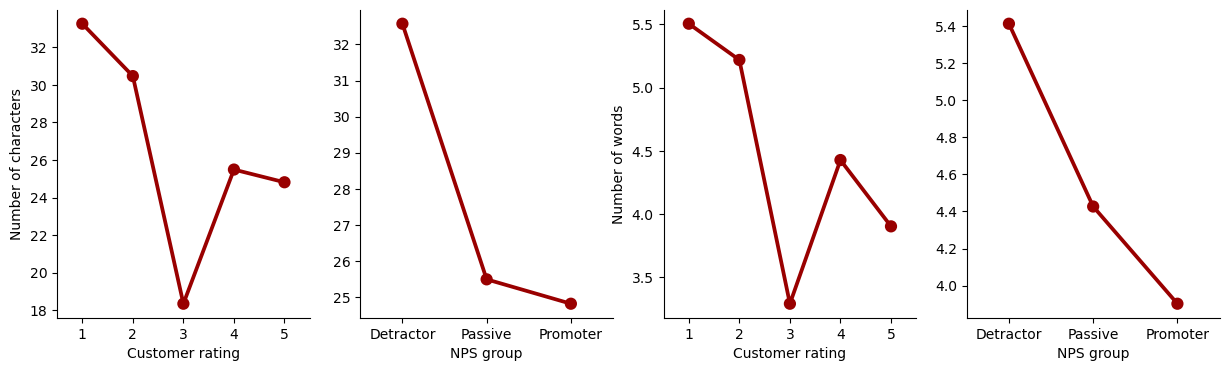

In [86]:
# an alternative representation using seaborn pointplots
fig, axs = plt.subplots(1, 4, figsize = (15, 4))
p = sns.pointplot(ax=axs[0], data=vodafone_reviews, x='score', y='text_num_chars', color='#990000', ci=None)
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)
p.set_xlabel("Customer rating")
p.set_ylabel("Number of characters")
p2 = sns.pointplot(ax=axs[1], data=vodafone_reviews, x='nps_group', y='text_num_chars', color='#990000', ci=None)
p2.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.set_xlabel("NPS group")
p2.set_ylabel("")
p3 = sns.pointplot(ax=axs[2], data=vodafone_reviews, x='score', y='text_num_words', color='#990000', ci=None)
p3.spines['right'].set_visible(False)
p3.spines['top'].set_visible(False)
p3.set_xlabel("Customer rating")
p3.set_ylabel("Number of words")
p2 = sns.pointplot(ax=axs[3], data=vodafone_reviews, x='nps_group', y='text_num_words', color='#990000', ci=None)
p2.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.set_xlabel("NPS group")
p2.set_ylabel("");
# plt.show()

# reset the default figure size
plt.rcdefaults()

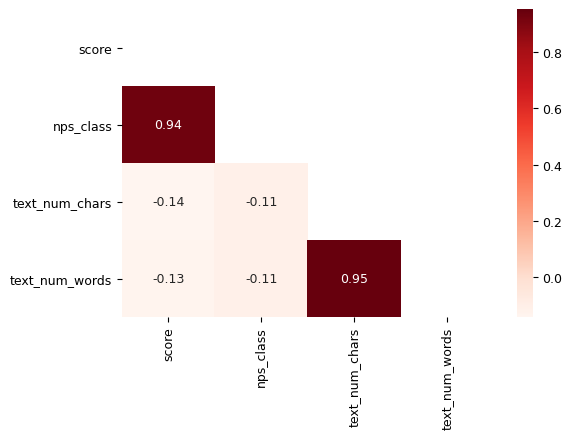

In [91]:
# calculate and plot the correlation between nps_group, customer rating, and title and review lengths
numeric_features = vodafone_reviews.loc[:, ['score', 'nps_class', 'text_num_chars', 'text_num_words']]
corr = numeric_features.corr()

fig, ax = plt.subplots(figsize = (6, 4))
mask = np.zeros_like(numeric_features.corr())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(numeric_features.corr(), mask=mask, ax=ax, annot=True, cmap='Reds');
# plt.show()

# reset the default figure size
plt.rcdefaults()

#### Step 3: Data cleansing and normalisation pipeline

In [ ]:
def preprocess_review_text():
    # remove special characters

    # convert the text to lower-case
    vodafone_reviews['lower_text'] = vodafone_reviews.text.str.lower()

    # correct curly apostrophes
    vodafone_reviews.lower_text = vodafone_reviews.lower_text.str.replace("’", "'", regex=False)

    # create a dictionary of common expansions in the english language
    contractions_dict = {"can't": "can not",
                         "won't": "will not",
                         "don't": "do not",
                         "n't":" not",
                         "'m":" am",
                         "'ll":" will",
                         "'d":" would",
                         "'ve":" have",
                         "'re":" are",
                         "'s": ""} # 's could be 'is' or could be possessive: it has no expansion

    # expand the contractions and add to dataframe as new variable
    exp_reviews = []
    for title in vodafone_reviews.lower_title:
        t = []
        for key, value in contractions_dict.items():
            if key in title:
                title = title.replace(key, value)
                t.append(title)
        exp_reviews.append(t)

    vodafone_reviews['clean_title'] = exp_reviews
    vodafone_reviews.clean_title = vodafone_reviews.apply(lambda x: x.clean_title[0] if len(x.clean_title) > 0 else x.lower_title, axis = 1)

    # correct spelling mistakes (haven't found an autocorrect package that works yet)
    
    
    # remove punctuation
    vodafone_reviews.clean_title = vodafone_reviews['clean_title'].str.replace('[^\w\s]', '', regex=True)

    # part-of-speech tagging - this step takes a bit of time
    words = []
    poss = []
    pos_tags = []
    ner_types = []
    for title in vodafone_reviews.clean_title:
        word = []
        pos = []
        pos_tag = []
        ner_type = []
        t = nlp_trf(title)
        for w in t:
            word.append(w.text)
            pos.append(w.pos_)
            pos_tag.append(w.tag_)
            ner_type.append(w.ent_type_)
        words.append(word)
        poss.append(pos)
        pos_tags.append(pos_tag)
        ner_types.append(ner_type)

    vodafone_reviews['title_words'] = words
    vodafone_reviews['title_pos'] = poss
    vodafone_reviews['title_pos_tags'] = pos_tags
    vodafone_reviews['title_ner_types'] = ner_types

    # pulling out named entities (organisations, money, dates etc) - again, this takes a bit of time
    ent_texts = []
    ent_labels = []
    for title in nlp_trf.pipe(vodafone_reviews.clean_title):
        ent_text = []
        ent_label = []
        for ent in title.ents:
            ent_text.append(ent.text)
            ent_label.append(ent.label_)
        ent_texts.append(ent_text)
        ent_labels.append(ent_label)

    vodafone_reviews['title_ent_text'] = ent_texts
    vodafone_reviews['title_ent_label'] = ent_labels

    # check out spacy's stopword list and modify as necessary
    spacy_stopwords = nlp_sm.Defaults.stop_words # stopwords are the same irrespective of the English language model used

    preproc_titles = []
    preproc_poss = []
    preproc_pos_tags = []
    for title in vodafone_reviews.clean_title:
        titles = []
        pos = []
        pos_tag = []
        t = nlp_trf(title)
        for w in t:
            if not w.is_stop and not w.is_punct and not w.is_digit and not w.is_space:
                titles.append(w.lemma_)
                pos.append(w.pos_)
                pos_tag.append(w.tag_)
        preproc_titles.append(titles)
        preproc_poss.append(pos)
        preproc_pos_tags.append(pos_tag)

    vodafone_reviews['preproc_title'] = preproc_titles
    vodafone_reviews['preproc_title_pos'] = preproc_poss
    vodafone_reviews['preproc_title_pos_tag'] = preproc_pos_tags

    title_bigram_model = gensim.models.Phrases(preproc_titles)
    title_bigrams = [title_bigram_model[title] for title in preproc_titles]

    title_trigram_model = gensim.models.Phrases(title_bigrams)
    title_trigrams = [title_trigram_model[title] for title in title_bigrams]

    vodafone_reviews['preproc_title_bigrams'] = title_bigrams
    vodafone_reviews['preproc_title_trigrams'] = title_trigrams

    return vodafone_reviews